# Bulk analysis of constant velocity experiments
In this notebook we take a large number of constant velocity traces and inspect each of them for:
- Unfolding events
- Experimental errors
  - Multiple tethers
  - Bead loss

After which we determine the contour lengths of unfolded domains as well as their unfolding forces, by fitting each curve with Odijk and Marko-Siggia models (for DNA handles and unfolded protein respectively).

The script is designed to be run in order and may break otherwise.
For more technical details, see the files that are imported. 
Specifically ```curve.py``` contains the code used in the analysis steps and includes some documentation.

In [1]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

from curve import Curve

## Defining models

Here we define our models. As long as the below estimates correspond, you should be able to change these. The name strings (```'handles'``` and ```'protein'```) feature as part of parameter names and these should stay consistent.

In [2]:
# these dont have to be build functions, can just be model objects
def build_handles_model():
    return lk.inverted_odijk('handles') + lk.force_offset('handles')
def build_composite_model():
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    return comp_wrt_f.invert(interpolate = True, 
                             independent_min = 0,
                             independent_max = 90) + lk.force_offset('handles')

## Providing estimates

Here we provide some initial guesses for the model parameters in a dictionary format.

For each parameter, the possible entries are ```'value'```, ```'upper_bound'```, ```'lower_bound'``` and ```'fixed'```, where the latter fixes the parameter value to that in the 'value' field.

In [3]:
from build_config import bp2cl

handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 0.0},
     'handles/Lc':  # contour length (um)
      {'value': 0.3},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 250},
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': True}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }

## Providing data
Each separate pulling curve will be put in a ```Curve``` object.
This means for each pull, you will need to supply:
- an identifier string
- distance data (a 1d numpy array or something similar, like a list)
- force data (same)

This assumes the force and distance data describe the entire pull (extension, stationary, return).
If possible, also supply only the extension part of the curve, with the ```pull_d``` and ```pull_f``` arguments
(this is a bit messy, should probably change the way we handle this).

For this script, each ```Curve``` object should be put in a dictionary called ```fdcurves```.
This should look something like the following:
```
fdcurves = {'curve_01': Curve('curve_01', dist_data_full, force_data_full, 
                               pull_d=dist_data_pull, pull_f=force_data_pull)
            'curve_02': Curve('curve_02', ...),
            ...}                               
```

In [4]:
## example:
# fdcurves = {}
# from some_file_with_data import many_distance_series, many_force_series
# for i in range(len(many_distances)):
#     identifier = 'my_curve_' + str(i)
#     fdcurves[identifier] = Curve(identifier, many_distance_series[i], many_force_series[i])

### For some specific large sets of data, we can split up and enter data automatically
In that case run this next cell, which uses the ```autosplit``` function.
The argument it takes is the path to your data file (here ```'/home/kris/proj/.data/tweez/yhsp2.h5'```).

The function may take a while.
It also spits out a bunch of nonsense you can ignore (this is true for many other cells as well and should be removed in the future).

[[1313248]
 [1313249]
 [1313250]
 ...
 [3148566]
 [3148589]
 [3148591]]
1313248 2031085
len 51910866
ppp: 380151
60
ditch: 2211085 -0.06602287236124087


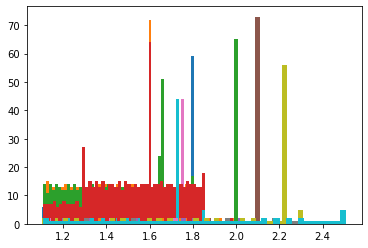

In [5]:
import h5py
from autosplit import autosplit

split_curves = autosplit('/home/kris/proj/.data/tweez/yhsp2.h5')

fdcurves = {}  # clear fdcurces
for key, curve in split_curves.items():
    fdcurves[key] = Curve(key, *[curve[dname]
                                for dname in ['full_dist', 'full_force',
                                              'pull_dist', 'pull_force',
                                              'rlx_dist', 'rlx_force']])

## Bead loss errors
Data featuring force suddenly dropping to zero can dramatically slow down the event-finding and fitting steps, so we filter those out first. Other error-finding operations depend on the events found below and will happen later.

This has missed cases in the past. You have an opportunity to verify on the next step.

In [6]:
lost_bead_fdcurves = {}
for curve_id, curve in fdcurves.items():
    if curve.filter_bead_loss(handle_contour = handle_estimates['handles/Lc']['value']):
        lost_bead_fdcurves[curve_id] = curve
for curve_id in lost_bead_fdcurves.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

curve_01
curve_60


## Event-finding
Here we try to find unfolding events, using the ```Curve.find_events()``` function.
If the supplied data did not have separate extension curves and is of the entire pull (extension, stationary, return),
this part will first split out the extension parts. 
This is already done if you used the autosplit way of entering data.

Curves are then split into 'legs' of datapoints between events, and those legs are used to fit our different models. 
The ```SHOW_PLOTS``` variable determines if we plot each curve, showing the different events and legs (green: legs, orange: unfolding events).
Large numbers of plots can use a lot of resources (in memory: you might get a warning about it), but can be good to verify if the curves look like they should.

```curve.find_events(..., splines=True)``` is better at finding small events, but you may want to check for false positives. ```splines=False``` is bad at small events but does not find false positives.

/home/kris/proj/tweez-CV/curve.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


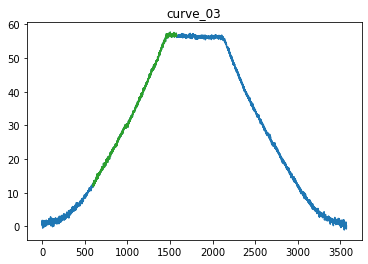

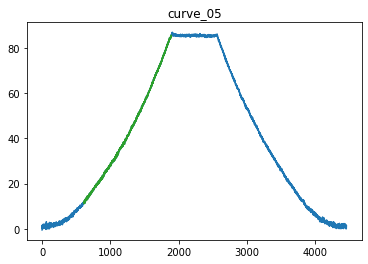

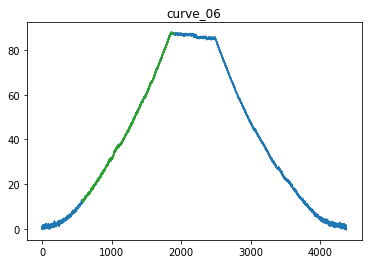

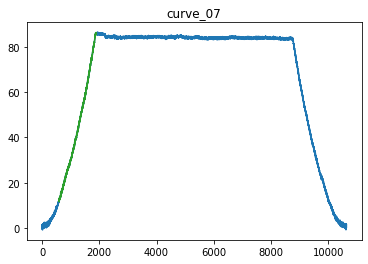

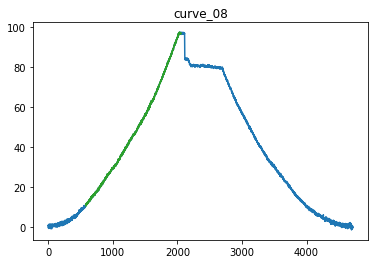

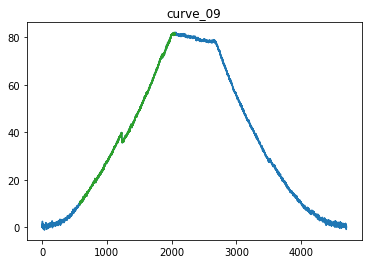

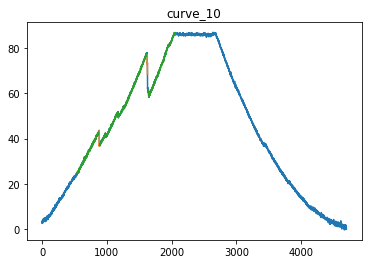

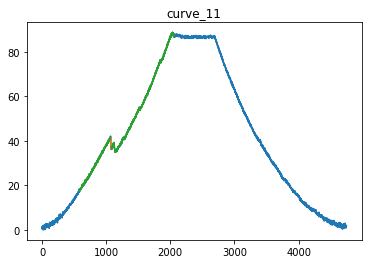

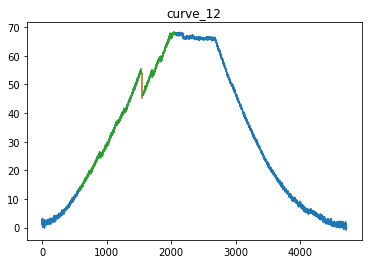

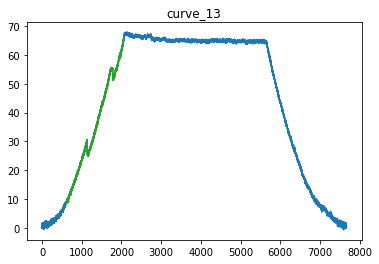

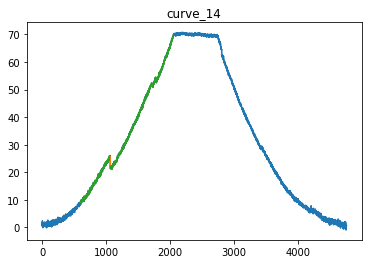

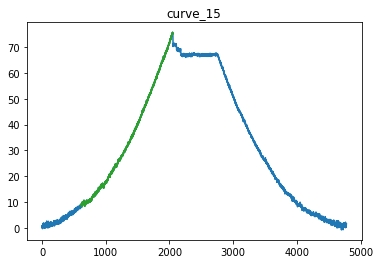

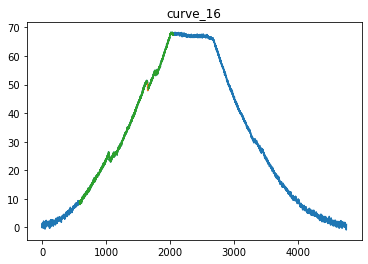

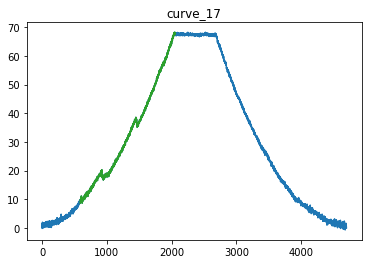

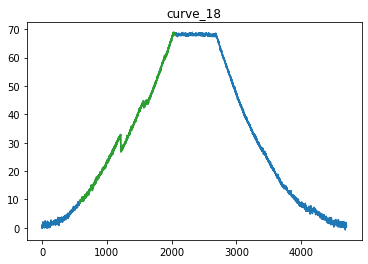

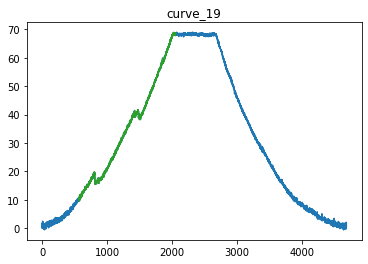

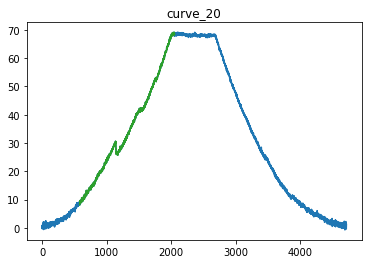

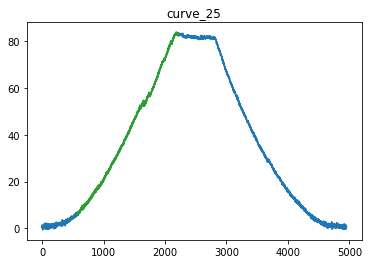

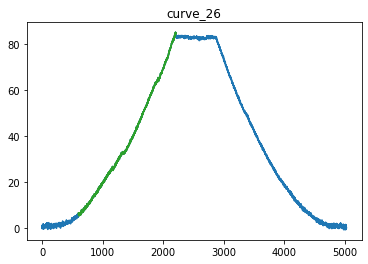

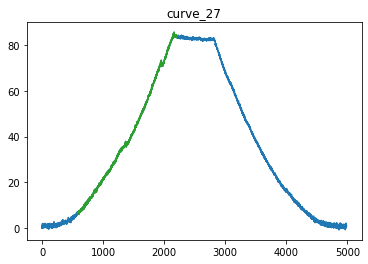

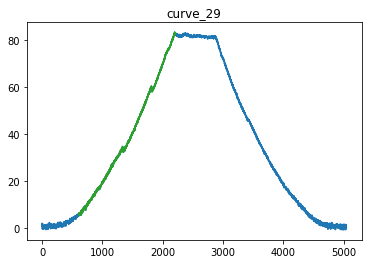

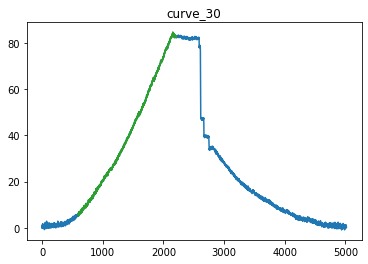

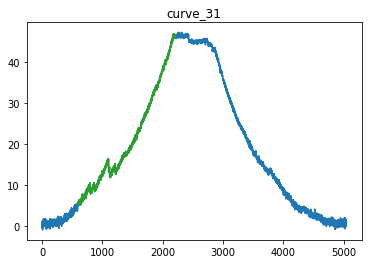

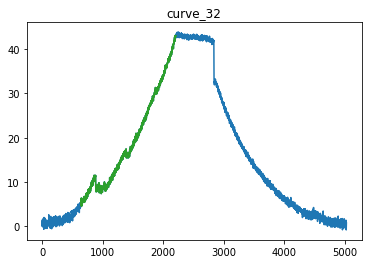

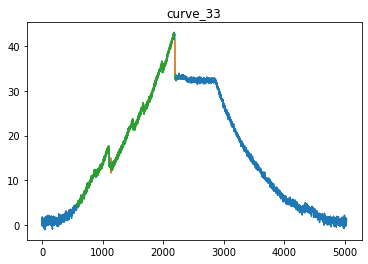

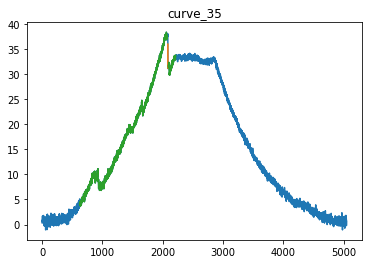

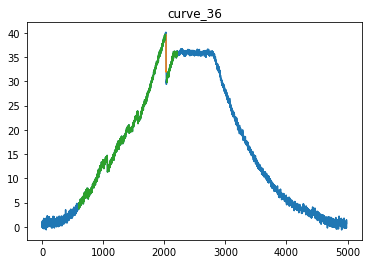

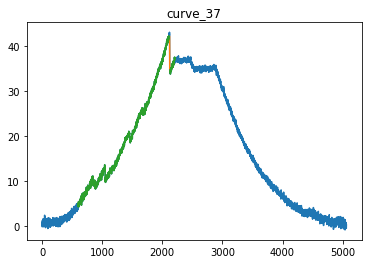

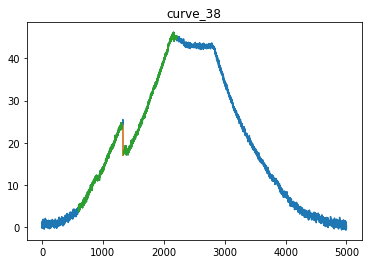

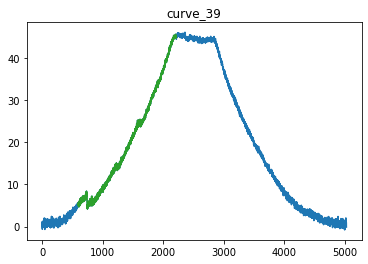

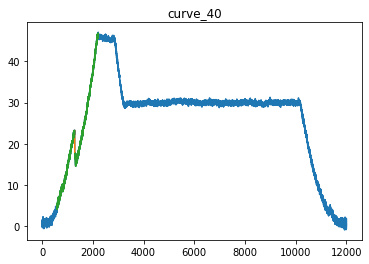

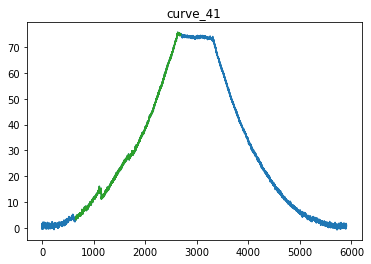

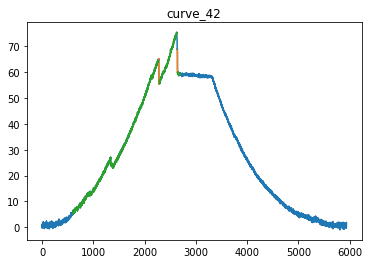

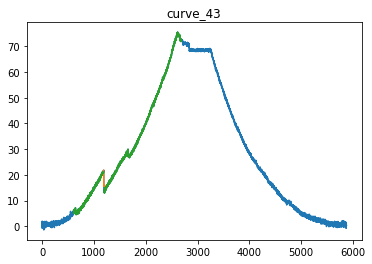

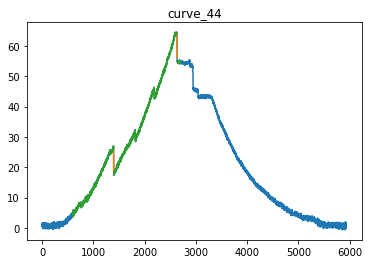

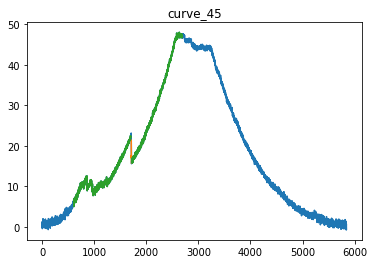

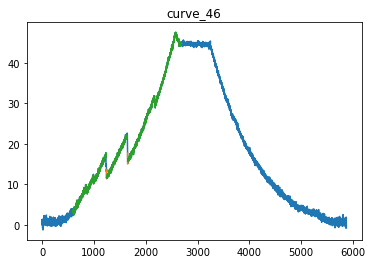

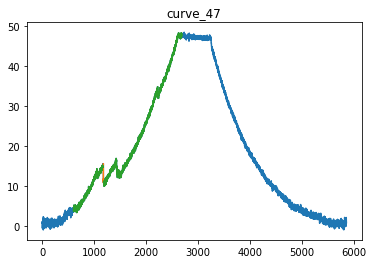

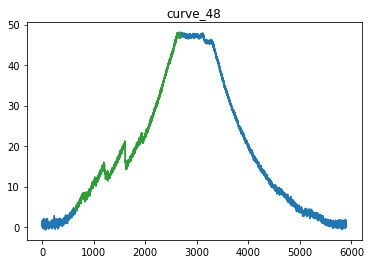

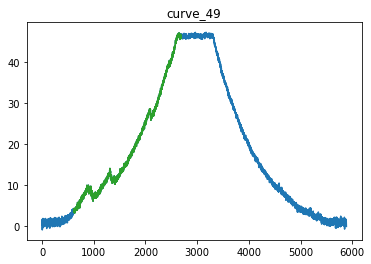

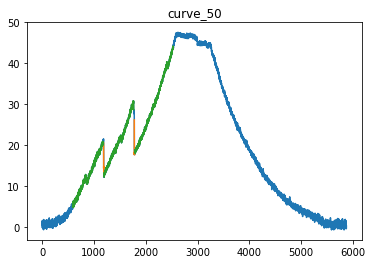

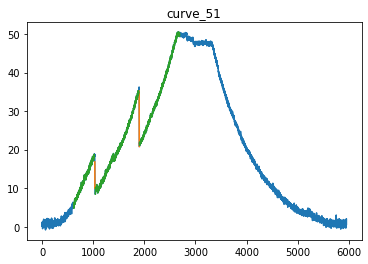

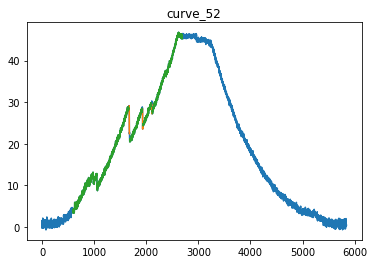

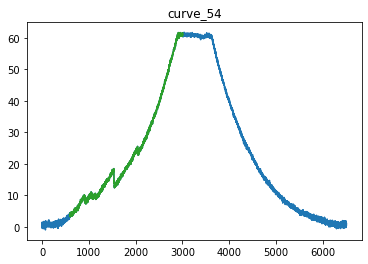

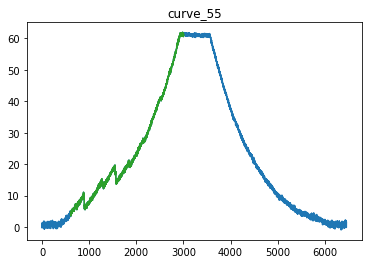

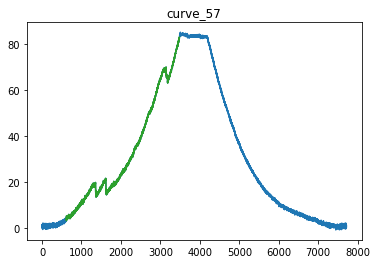

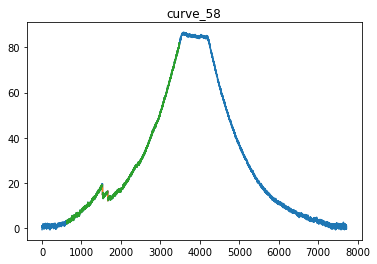

In [17]:
SHOW_PLOTS = True
%matplotlib inline

for curve in fdcurves.values():
    #print(curve.identifier)
    curve.find_events(DEBUG=False, handle_contour = handle_estimates['handles/Lc']['value'], splines=False)
    #print(curve.top)
    if SHOW_PLOTS:
        curve.plot_events()
# plot force over time (or number of measurements)
# green: fitted leg, orange: unfold event, red: return/stationary point


Here, curves where no unfolding events were found will be filtered out.

If you saw any curve above that did show an unfolding event, but looked suspicious, you can choose to filter it out yourself.

To hand-remove curves, change the ```my_filter``` list to include the identifiers (plot titles above) of the curves you want removed.

Later on, if something breaks, it should be possible to see which curve is the culprit (curve ids are printed at each step).
You can return here and add that curve to your filter.

In [19]:
# example:
# my_filter = ['curve_05', 'curve_12']
my_filter = []
for curve_id in my_filter:
    fdcurves.pop(curve_id)

no_unfolds = {}
for curve_id, curve in fdcurves.items():
    if not curve.unfolds.any(): #or not curve_id == 'split_curve9':
        no_unfolds[curve_id] = curve  
for curve_id in no_unfolds.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

curve_03
curve_05
curve_06
curve_07
curve_08
curve_09
curve_13
curve_15
curve_17
curve_18
curve_19
curve_20
curve_25
curve_26
curve_27
curve_29
curve_30
curve_31
curve_32
curve_39
curve_41
curve_48
curve_49
curve_54
curve_55
curve_57


In [20]:
# Print out unfolding events
# for curve_id, curve in fdcurves.items():
#    print(curve_id)
#     #print(curve.top)
#     print(curve.unfolds)

## Error-finding
##### Multiple tethers
We filter multiple tethers comparison of the model as given in the estimates, with exaggerated parameters or data. The tests we perform include:
- A doubled persistence length
- A halved contour length
- Halved force data
- Doubled distance data

These should in theory test the single-tether case against the double-tether case. For a greater number of tethers we assume a double-tether model would fit better than a single-tether one. We compare the resulting BICs to determine pass or fail. We also compute Bayes factors for relative likelihood comparisons, but those turn out rather extreme.

Doubling the persistence length yields false positives and does not seem to be a good way to approximate a double tether. Some higher factor would probably work but for now we can just ignore that test.

We may want to hide some of this code behind an import

Halving contour length appears functionally identical to doubling the distance data, so we can do away with one.
# This doesn't really seem to work so take it with a grain of salt.
The cell will spit out a lot of text. 
If it shows any ```True```s that means it thinks you have a multiple tether.
The doubled persistence length method seems to be the only one to actually work, but gives false positives as well.
You may want to fiddle around with the exact values: 
perhaps some other factor of the initially estimated persistence length works better.

In [21]:
from copy import deepcopy

original = handle_estimates
double_Lp = deepcopy(original)
half_Lc = deepcopy(original)
double_Lp['handles/Lp']['value'] = original['handles/Lp']['value'] * 2
half_Lc['handles/Lc']['value'] = original['handles/Lc']['value'] / 2

test_estimates = {'original': original, 'double_Lp': double_Lp, 
                  'half_Lc': half_Lc, 'half_force': original,
                  'double_dist': original}

for curve in fdcurves.values():
    print(curve.identifier)
    curve.filter_tethers(build_handles_model(), test_estimates)

curve_10
curve_10 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_11
curve_11 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_12
curve_12 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_14
curve_14 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_16
curve_16 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_33
curve_33 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_35
curve_35 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_36
curve_36 
 {'double_dist': False, 'half_force': False, 'half_Lc': False, 'original': False, 'double_Lp': True}
curve_37
curve_37 
 {'double_dist': Fals

## Fitting

Here we fit our models. We first define fits for each unfolding event, and proliferate a single fit of the DNA handles parameters to each of them. After that, we fit the remaining protein parameters with the legs we defined before. The third cell draws plots and shows parameter summaries for each curve.

This first one just shows which 

In [22]:
for curve in fdcurves.values():
    print(curve.identifier, curve.legs)

curve_10 [slice(542, 872, None), slice(892, 1613, None), slice(1633, 2054, None)]
curve_11 [slice(586, 1063, None), slice(1083, 2054, None)]
curve_12 [slice(577, 1536, None), slice(1556, 2054, None)]
curve_14 [slice(610, 1056, None), slice(1076, 2054, None)]
curve_16 [slice(586, 1642, None), slice(1662, 2054, None)]
curve_33 [slice(591, 1124, None), slice(1144, 2184, None), slice(2204, 2213, None)]
curve_35 [slice(628, 2074, None), slice(2094, 2213, None)]
curve_36 [slice(599, 2018, None), slice(2038, 2213, None)]
curve_37 [slice(602, 2112, None), slice(2132, 2213, None)]
curve_38 [slice(598, 1317, None), slice(1337, 2213, None)]
curve_40 [slice(595, 1277, None), slice(1297, 2213, None)]
curve_42 [slice(599, 2267, None), slice(2287, 2630, None), slice(2650, 2689, None)]
curve_43 [slice(612, 1180, None), slice(1200, 2689, None)]
curve_44 [slice(599, 1386, None), slice(1406, 2621, None), slice(2641, 2689, None)]
curve_45 [slice(607, 1702, None), slice(1722, 2689, None)]
curve_46 [slice(5

In [23]:
#fdcurves.pop('split_curve4')
#fdcurves.pop('split_curve9')
#fdcurves.pop('split_curve5')

for curve in fdcurves.values():
    print(curve.identifier)
    curve.initialize_fits(build_handles_model(),
                         build_composite_model(),
                         handle_estimates)

curve_10
curve_11
curve_12
curve_14
curve_16
curve_33
curve_35
curve_36
curve_37
curve_38
curve_40
curve_42
curve_43
curve_44
curve_45
curve_46
curve_47
curve_50
curve_51
curve_52
curve_58


In [ ]:
# some fits may take a while. should finish though
for curve_id, curve in fdcurves.items():
    print(curve_id)
    curve.fit_composites(protein_estimates)

curve_10


/home/kris/.pyenv/versions/3.8.6/envs/tweez-3.8.6/lib/python3.8/site-packages/lumicks/pylake/fitting/fit.py:232: RuntimeWarning: invalid value encountered in sqrt
  self.params[name].stderr = np.sqrt(value)


curve_11
curve_12
curve_14
curve_16
curve_33
curve_35
curve_36
curve_37
curve_38
curve_40
curve_42
curve_43
curve_44
curve_45
curve_46
curve_47
curve_50
curve_51
curve_52
curve_58


In [ ]:
%matplotlib inline
for curve in fdcurves.values():
    curve.plot_fits()
    plt.show()
    curve.print_fit_params()

#### Computing unfolding forces
We compute the force for each unfolding event by simulating the fitted model to the distance slightly before the unfolding event. This part is lacking an error estimation.

In [ ]:
for curve in fdcurves.values():
    curve.compute_unfold_forces(build_handles_model(), build_composite_model())

#### Result summary table
Prints a summary table containing fitted contour length, persistence length and unfolding force for each unfolding domain. Could be prettier.
Needs to be changed to also write to file.

In [ ]:
# score and/or rank by fit quality

# make a format string for the column widths
largest_id_len = max([len(id) for id in fdcurves.keys()])
row_format = f'{{:<{largest_id_len + 1}}}| {{:<5}}| {{:<9}}| {{:<9}}| {{:<9}}| {{}}'

print(row_format.format('Curve', 'fold', 'Lc (um)', 'Lp (nm)', 'Fu (pN)',
                        'failed tests'))
for curve_id, curve in fdcurves.items():
    curve.print_result_rows(row_format)

if lost_bead_fdcurves:
    print('\nBead losses for curves', [curve_id for curve_id in
                                       lost_bead_fdcurves.keys()])